# Model selection and evaluation

## 0.0 Notebook setup

### X.X Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
! mkdir data

In [5]:
! cp "/content/gdrive/My Drive/colab-data/combined.csv" ./data/

In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10764011404326698806
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13949457746813369940
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [8]:
!pip install --quiet transformers

     |████████████████████████████████| 4.0 MB 7.8 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
     |████████████████████████████████| 895 kB 42.5 MB/s 
     |████████████████████████████████| 6.5 MB 38.2 MB/s 


### X.X General setup

In [9]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [11]:
# Statistics
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc, accuracy_score

# Model building
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Dense, Flatten, LSTM, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# BERT-specific
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [13]:
# Local
# data = '../data/combined.csv'

# Colab
data = './data/combined.csv'

review_samples = pd.read_csv(data)

In [14]:
# Create sentiment axis label for plots
sentiment = ['Not Useful', 'Useful']

# Check split of useful / not useful
review_samples['useful'].value_counts()

1    2839
0    1616
Name: useful, dtype: int64

## X.X Electronics

In [87]:
electronics = review_samples[review_samples['category'] == 'electronics']
labels = electronics['useful'].astype(int)

### X.X Naive Bayes - Electronics

In [88]:
reviews = electronics['review_processed'].fillna('no review')

In [89]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_dev_tfidf = tf_idf.transform(X_dev)
X_test_tfidf = tf_idf.transform(X_test)

# Use SMOTE to resolve class imbalance
sm = SMOTE(random_state=0)
X_train_tfidf, y_train = sm.fit_resample(X_train_tfidf, y_train)

In [90]:
# Build model
nb_model = MultinomialNB(alpha=1.8)

# Fit model
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.8)

In [91]:
# Evaluate model accuracy
train_acc = nb_model.score(X_train_tfidf, y_train)
dev_acc = nb_model.score(X_dev_tfidf, y_dev)
test_acc = nb_model.score(X_test_tfidf, y_test)

print(train_acc, dev_acc, test_acc)

0.9952718676122931 0.5483870967741935 0.592741935483871


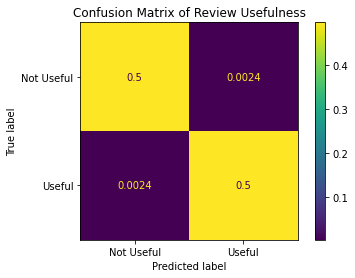

In [92]:
# Plot confusion matrix on training data
y_true = y_train
y_pred = nb_model.predict(X_train_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

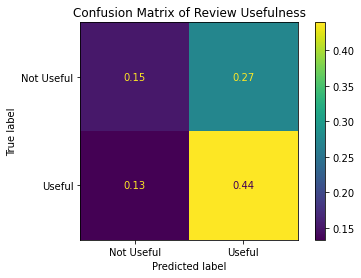

In [93]:
# Evaluate model on test data and plot confusion matrix
y_true = y_test
y_pred = nb_model.predict(X_test_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

AUC: 0.5630


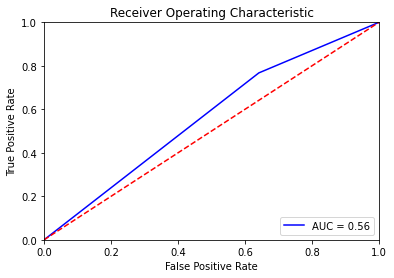

In [94]:
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [97]:
# Evaluate model
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(test_acc, precision, recall, f1))

Model performance metrics on test data
Accuracy: 0.5927
Precision: 0.5814
Recall: 0.5927
F1-score: 0.5748


### X.X Tokenization and analytics - Electronics

In [66]:
# Set tokenization parameters
num_words = 4000
num_len = 512
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize review text
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Additional tokenization parameters
max_words = len(tokenizer.word_index)
max_len = max([len(x) for x in sequences])

# Pad review text tokens
review_tokens = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=num_len)

In [67]:
len(tokenizer.word_counts)

6052

In [68]:
vocab = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'frequency'])
vocab.sort_values('frequency', ascending=False).head(10)

,word,frequency
14,sound,656
82,use,629
63,work,561
13,good,513
179,one,455
49,great,438
96,get,411
74,headphone,391
11,speaker,388
2,well,332


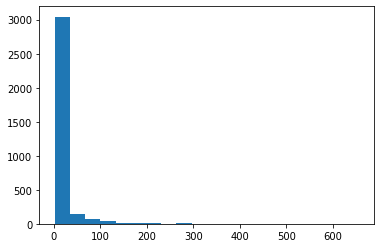

In [69]:
filtered_vocab = vocab[vocab['frequency'] > 1]
plt.hist(filtered_vocab['frequency'], bins=20)
plt.show()

In [70]:
print('Max words in vocabulary: {}'.format(max_words))
print('Max sequence length: {}'.format(max_len))
print('\n')

print('Words allowed in vocabulary: {}'.format(num_words))
print('Allowed sequence length: {}'.format(num_len))
print('\n')

print('Example processed review:')
print(review_samples['review_processed'].iloc[0])
print('\n')

print('Example tokenized review:')
print(review_tokens[0])

Max words in vocabulary: 6053
Max sequence length: 977


Words allowed in vocabulary: 4000
Allowed sequence length: 512


Example processed review:
works pissa


Example tokenized review:
[ 222 3343    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 

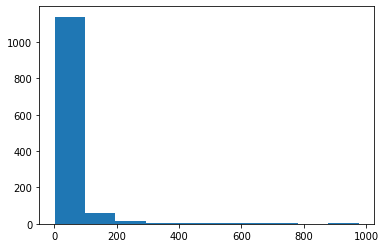

In [71]:
seq_len = [len(x) for x in sequences]
d = {'sequence': sequences, 'length': seq_len}
seqs = pd.DataFrame(data = d)

plt.hist(seqs['length'])
plt.show()

In [72]:
seqs[seqs['length'] > 512]

,sequence,length
21,"[1462, 3361, 162, 207, 104, 451, 6, 3362, 974,...",838
69,"[3461, 79, 291, 1187, 91, 181, 1500, 15, 41, 7...",616
157,"[663, 3662, 602, 3663, 25, 9, 1365, 3, 941, 53...",977
395,"[2835, 1891, 135, 582, 2836, 2837, 582, 217, 2...",951
618,"[55, 335, 23, 47, 16, 18, 279, 393, 21, 937, 5...",749
666,"[257, 1224, 577, 2313, 40, 279, 53, 130, 52, 1...",701
682,"[2835, 1891, 135, 582, 2836, 2837, 582, 217, 2...",951
793,"[280, 3097, 274, 181, 1, 47, 36, 221, 181, 15,...",585
930,"[280, 3097, 1, 1024, 16, 40, 36, 805, 868, 102...",897
1086,"[352, 103, 868, 55, 17, 642, 40, 1454, 9, 168,...",652


### X.X CNN - Electronics

In [73]:
# Set model hyperparamters
output_dim = 256
epochs = 10
batch_size = 512
dropout_rate = 0.0
num_classes = len(np.unique(labels, axis=0))
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               epsilon=0.00000001,
                               clipnorm=1.0
                              )
loss_func = 'binary_crossentropy'
metrics = ['accuracy']

In [74]:
# # Split data into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(review_tokens, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Use SMOTE to balance the training set
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [75]:
y_test.shape

(248,)

In [76]:
# Build model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=num_words, output_dim=output_dim, input_length=num_len))
cnn_model.add(Conv1D(16, 3, padding='same', activation='relu'))
# cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer=opt, loss=loss_func, metrics=metrics)
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 256)          1024000   
                                                                 
 conv1d (Conv1D)             (None, 512, 16)           12304     
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,133,969
Trainable params: 3,133,969
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Fit model
cnn_model.fit(X_train,
              y_train,
              validation_data=(X_dev, y_dev),
              epochs=epochs,
              batch_size=batch_size,
              verbose=2
             )

Epoch 1/10
2/2 - 8s - loss: 0.7009 - accuracy: 0.4634 - val_loss: 0.7399 - val_accuracy: 0.5484 - 8s/epoch - 4s/step
Epoch 2/10
2/2 - 0s - loss: 0.7422 - accuracy: 0.5000 - val_loss: 0.6914 - val_accuracy: 0.5444 - 112ms/epoch - 56ms/step
Epoch 3/10
2/2 - 0s - loss: 0.6784 - accuracy: 0.6950 - val_loss: 0.6913 - val_accuracy: 0.5282 - 105ms/epoch - 53ms/step
Epoch 4/10
2/2 - 0s - loss: 0.6684 - accuracy: 0.7849 - val_loss: 0.6882 - val_accuracy: 0.5766 - 107ms/epoch - 53ms/step
Epoch 5/10
2/2 - 0s - loss: 0.6510 - accuracy: 0.7671 - val_loss: 0.6856 - val_accuracy: 0.5766 - 106ms/epoch - 53ms/step
Epoch 6/10
2/2 - 0s - loss: 0.6274 - accuracy: 0.7447 - val_loss: 0.6843 - val_accuracy: 0.5766 - 110ms/epoch - 55ms/step
Epoch 7/10
2/2 - 0s - loss: 0.5992 - accuracy: 0.7600 - val_loss: 0.6816 - val_accuracy: 0.5887 - 108ms/epoch - 54ms/step
Epoch 8/10
2/2 - 0s - loss: 0.5650 - accuracy: 0.8251 - val_loss: 0.6786 - val_accuracy: 0.6048 - 108ms/epoch - 54ms/step
Epoch 9/10
2/2 - 0s - loss: 0

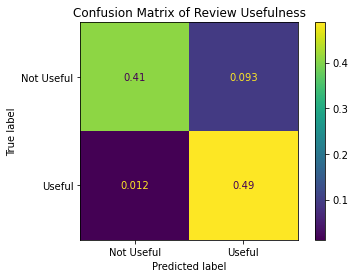

In [ ]:
# Plot confusion matrix on training data
y_true = y_train
y_pred = (cnn_model.predict(X_train) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

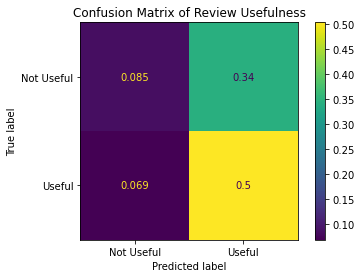

In [ ]:
# Plot confusion matrix
y_true = y_test
y_pred = (cnn_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.20      0.29       106
           1       0.60      0.88      0.71       142

    accuracy                           0.59       248
   macro avg       0.57      0.54      0.50       248
weighted avg       0.58      0.59      0.53       248



In [ ]:
# Evaluate model
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=1)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

8/8 [==============================] - 0s 12ms/step - loss: 0.6939 - accuracy: 0.5887
Model performance metrics on test data
Accuracy: 0.5887
Loss: 0.6939
Precision: 0.5770
Recall: 0.5887
F1-score: 0.5313


In [ ]:
example0 = "Golf tips magazine is one of the most aptly titled magazines available today. \
            It is chock full of heavily-illustrated exercises and other tips for serious golfers to improve their games.\
            \nThere are a number of golf magazines on the newstand today. Most of them rely on a lifestyle format relying \
            more heavily on lifestyle-type stories about today's hot golfers and the courses they play. Most of them include \
            a brief game tip or two but seem aimed at the casual duffer.\nGolf Tips, on the other hand, features almost nothing \
            but heavily illustrated tips on improving one's swing, eliminating mistakes and putting better. It also is heavily \
            loaded with features on the latest equipment technology. Each issue also seems to feature an article on the technical \
            aspects of a selected major golf course. The articles are written with terminology that serious golfers will understand \
            but that may confuse the weekend player. Judging by the amount of advertising in its early issues, this magazine also \
            appears to be financially healthy.\nIf a reader wants to read about the PGA Tour's superstars, this magazine is not for \
            him/her. But if s/he plans to be one of those superstars, Golf Tips is a good match."

example1 = "The information is interesting and fun, the writing is superb, and the writers and editors have a great sense of humor. \
            I just wish it came out more often!"

example2 = "this data science article is the best ever"

example3 = "i really loved how the technician helped me with the issue that i had"

example4 = "useless comment"

examples = [example0, example1, example2, example3, example4]

In [ ]:
def test_examples(model, examples, num_len=512):
    for idx, example in enumerate(examples):
        sequence = tokenizer.texts_to_sequences([example])
        test = pad_sequences(sequence, maxlen=num_len)
        prediction = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]
        print(idx, ":", prediction)

In [ ]:
test_examples(cnn_model, examples)

0 : Not Useful
1 : Not Useful
2 : Not Useful
3 : Not Useful
4 : Not Useful


### X.X BERT - Electronics

[TF BERT Tutorial](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

In [17]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 7.5 MB/s 
     |████████████████████████████████| 462 kB 48.7 MB/s 


In [18]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 7.7 MB/s 
     |████████████████████████████████| 99 kB 8.7 MB/s 
     |████████████████████████████████| 1.1 MB 45.1 MB/s 
     |████████████████████████████████| 352 kB 49.1 MB/s 
     |████████████████████████████████| 237 kB 49.9 MB/s 
     |████████████████████████████████| 1.2 MB 34.7 MB/s 
     |████████████████████████████████| 47.8 MB 45 kB/s 
     |████████████████████████████████| 43 kB 995 kB/s 
     |████████████████████████████████| 90 kB 6.6 MB/s 


In [19]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

In [20]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [21]:
reviews = electronics['review_text'].fillna('no review')

X, y = reviews, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [22]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [23]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.36462566]], shape=(1, 1), dtype=float32)


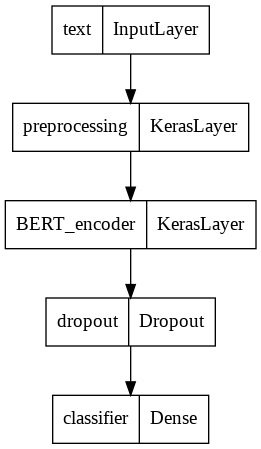

In [24]:
tf.keras.utils.plot_model(classifier_model)

In [25]:
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [33]:
epochs = 10
steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [34]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss_func,
                         metrics=metrics)

In [35]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_train,
                               y=y_train,
                               validation_data=(X_dev, y_dev),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
24/24 [==============================] - 14s 252ms/step - loss: 0.6337 - binary_accuracy: 0.5758 - val_loss: 0.6628 - val_binary_accuracy: 0.5403
Epoch 2/10
24/24 [==============================] - 5s 222ms/step - loss: 0.6221 - binary_accuracy: 0.6280 - val_loss: 0.6628 - val_binary_accuracy: 0.5323
Epoch 3/10
24/24 [==============================] - 5s 224ms/step - loss: 0.6091 - binary_accuracy: 0.6361 - val_loss: 0.6621 - val_binary_accuracy: 0.5363
Epoch 4/10
24/24 [==============================] - 5s 226ms/step - loss: 0.6077 - binary_accuracy: 0.6523 - val_loss: 0.6659 - val_binary_accuracy: 0.5685
Epoch 5/10
24/24 [==============================] - 5s 225ms/step - loss: 0.6097 - binary_accuracy: 0.6226 - val_loss: 0.6644 - val_binary_accuracy: 0.5726
Epoch 6/10
24/24 [==============================] - 5s 223ms/step - loss: 0.5884 - binary_accuracy: 0.6685 - val_loss: 0.6713 -

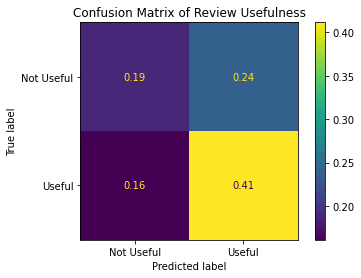

In [36]:
# Plot confusion matrix
y_true = y_test
y_pred = (classifier_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [37]:
# Evaluate model
loss, acc = classifier_model.evaluate(X_test, y_test)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

8/8 [==============================] - 1s 119ms/step - loss: 0.7296 - binary_accuracy: 0.6008
Model performance metrics on test data
Accuracy: 0.6008
Loss: 0.7296
Precision: 0.5937
Recall: 0.6008
F1-score: 0.5937


## X.X Furniture

In [98]:
furniture = review_samples[review_samples['category'] == 'furniture']
labels = furniture['useful'].astype(int)

### X.X Naive Bayes - Furniture

In [99]:
reviews = furniture['review_processed'].fillna('no review')

In [100]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_dev_tfidf = tf_idf.transform(X_dev)
X_test_tfidf = tf_idf.transform(X_test)

# Use SMOTE to resolve class imbalance
sm = SMOTE(random_state=0)
X_train_tfidf, y_train = sm.fit_resample(X_train_tfidf, y_train)

In [101]:
# Build model
nb_model = MultinomialNB(alpha=1.8)

# Fit model
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.8)

In [102]:
# Evaluate model accuracy
train_acc = nb_model.score(X_train_tfidf, y_train)
dev_acc = nb_model.score(X_dev_tfidf, y_dev)
test_acc = nb_model.score(X_test_tfidf, y_test)

print(train_acc, dev_acc, test_acc)

0.9912280701754386 0.6307277628032345 0.6199460916442049


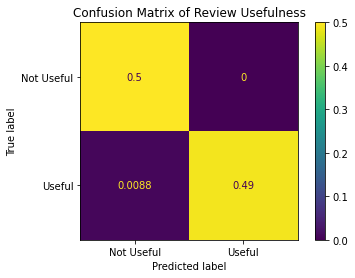

In [103]:
# Plot confusion matrix
y_true = y_train
y_pred = nb_model.predict(X_train_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

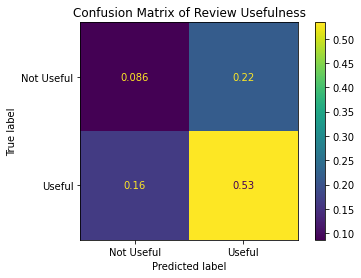

In [105]:
# Evaluate model on test data and plot confusion matrix
y_true = y_test
y_pred = nb_model.predict(X_test_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

AUC: 0.5251


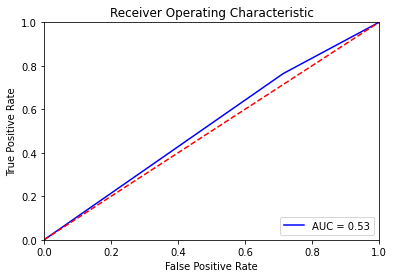

In [106]:
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [107]:
# Evaluate model
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(test_acc, precision, recall, f1))

Model performance metrics on test data
Accuracy: 0.6199
Precision: 0.6011
Recall: 0.6199
F1-score: 0.6091


### X.X Tokenization and analytics - Furniture

In [ ]:
# Set tokenization parameters
num_words = 4000
num_len = 512
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize review text
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Additional tokenization parameters
max_words = len(tokenizer.word_index)
max_len = max([len(x) for x in sequences])

# Pad review text tokens
review_tokens = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=num_len)

In [ ]:
len(tokenizer.word_counts)

5234

In [ ]:
vocab = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'frequency'])
vocab.sort_values('frequency', ascending=False).head(10)

,word,frequency
68,look,521
4,one,517
87,mattress,515
669,chair,488
93,get,480
94,bed,466
381,great,445
69,like,443
76,would,439
56,good,394


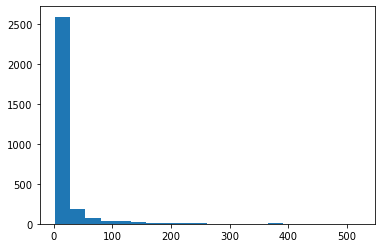

In [ ]:
filtered_vocab = vocab[vocab['frequency'] > 1]
plt.hist(filtered_vocab['frequency'], bins=20)
plt.show()

In [ ]:
print('Max words in vocabulary: {}'.format(max_words))
print('Max sequence length: {}'.format(max_len))
print('\n')

print('Words allowed in vocabulary: {}'.format(num_words))
print('Allowed sequence length: {}'.format(num_len))
print('\n')

print('Example processed review:')
print(review_samples['review_processed'].iloc[0])
print('\n')

print('Example tokenized review:')
print(review_tokens[0])

Max words in vocabulary: 5235
Max sequence length: 724


Words allowed in vocabulary: 4000
Allowed sequence length: 512


Example processed review:
works pissa


Example tokenized review:
[ 57  46 246  55   3 142  41 850   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 

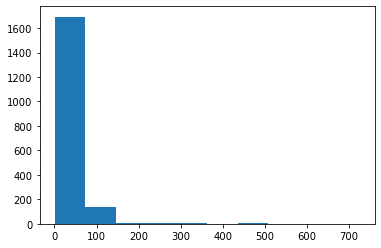

In [ ]:
seq_len = [len(x) for x in sequences]
d = {'sequence': sequences, 'length': seq_len}
seqs = pd.DataFrame(data = d)

plt.hist(seqs['length'])
plt.show()

In [ ]:
seqs[seqs['length'] > 512]

,sequence,length
282,"[3301, 2406, 910, 1387, 545, 58, 278, 99, 323,...",724


### X.X CNN - Furniture

In [ ]:
# Set model hyperparamters
output_dim = 256
epochs = 10
batch_size = 512
dropout_rate = 0.0
num_classes = len(np.unique(labels, axis=0))
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               epsilon=0.00000001,
                               clipnorm=1.0
                              )
loss_func = 'binary_crossentropy'
metrics = ['accuracy']

In [ ]:
# # Split data into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(review_tokens, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Use SMOTE to balance the training set
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
y_test.shape

(371,)

In [ ]:
# Build model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=num_words, output_dim=output_dim, input_length=num_len))
cnn_model.add(Conv1D(16, 3, padding='same', activation='relu'))
# cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer=opt, loss=loss_func, metrics=metrics)
cnn_model.summary()


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 512, 256)          1024000   
                                                                 
 conv1d_20 (Conv1D)          (None, 512, 16)           12304     
                                                                 
 flatten_19 (Flatten)        (None, 8192)              0         
                                                                 
 dense_43 (Dense)            (None, 256)               2097408   
                                                                 
 dense_44 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3,133,969
Trainable params: 3,133,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit model
cnn_model.fit(X_train,
              y_train,
              validation_data=(X_dev, y_dev),
              epochs=epochs,
              batch_size=batch_size,
              verbose=2
             )

Epoch 1/10
4/4 - 3s - loss: 0.7242 - accuracy: 0.4887 - val_loss: 0.6992 - val_accuracy: 0.3127 - 3s/epoch - 848ms/step
Epoch 2/10
4/4 - 2s - loss: 0.6879 - accuracy: 0.6071 - val_loss: 0.6791 - val_accuracy: 0.6253 - 2s/epoch - 597ms/step
Epoch 3/10
4/4 - 2s - loss: 0.6766 - accuracy: 0.6241 - val_loss: 0.6555 - val_accuracy: 0.6819 - 2s/epoch - 588ms/step
Epoch 4/10
4/4 - 2s - loss: 0.6612 - accuracy: 0.6203 - val_loss: 0.6429 - val_accuracy: 0.6523 - 2s/epoch - 605ms/step
Epoch 5/10
4/4 - 2s - loss: 0.6323 - accuracy: 0.6579 - val_loss: 0.6458 - val_accuracy: 0.5930 - 2s/epoch - 555ms/step
Epoch 6/10
4/4 - 2s - loss: 0.5878 - accuracy: 0.7325 - val_loss: 0.6521 - val_accuracy: 0.5687 - 2s/epoch - 552ms/step
Epoch 7/10
4/4 - 2s - loss: 0.5264 - accuracy: 0.8145 - val_loss: 0.6713 - val_accuracy: 0.5391 - 2s/epoch - 562ms/step
Epoch 8/10
4/4 - 2s - loss: 0.4499 - accuracy: 0.8484 - val_loss: 0.6775 - val_accuracy: 0.5553 - 2s/epoch - 592ms/step
Epoch 9/10
4/4 - 2s - loss: 0.3655 - acc

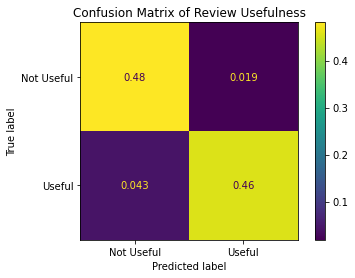

In [ ]:
# Plot confusion matrix on training data
y_true = y_train
y_pred = (cnn_model.predict(X_train) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

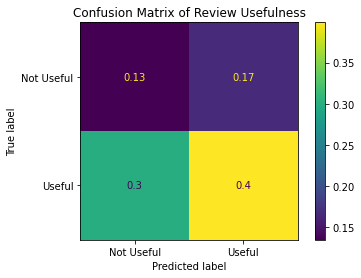

In [ ]:
# Plot confusion matrix
y_true = y_test
y_pred = (cnn_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.45      0.37       112
           1       0.70      0.57      0.63       259

    accuracy                           0.53       371
   macro avg       0.51      0.51      0.50       371
weighted avg       0.59      0.53      0.55       371



In [ ]:
# Evaluate model
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=1)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

12/12 [==============================] - 0s 11ms/step - loss: 0.7437 - accuracy: 0.5337
Model performance metrics on test data
Accuracy: 0.5337
Loss: 0.7437
Precision: 0.5858
Recall: 0.5337
F1-score: 0.5512


In [ ]:
def test_examples(model, examples, num_len=512):
    for idx, example in enumerate(examples):
        sequence = tokenizer.texts_to_sequences([example])
        test = pad_sequences(sequence, maxlen=num_len)
        prediction = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]
        print(idx, ":", prediction)

In [ ]:
test_examples(cnn_model, examples)

0 : Not Useful
1 : Not Useful
2 : Not Useful
3 : Not Useful
4 : Not Useful


### X.X BERT - Furniture

In [41]:
reviews = furniture['review_text'].fillna('no review')

X, y = reviews, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [42]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.47878563]], shape=(1, 1), dtype=float32)


In [43]:
epochs = 10
steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [44]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss_func,
                         metrics=metrics)

In [45]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_train,
                               y=y_train,
                               validation_data=(X_dev, y_dev),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
35/35 [==============================] - 21s 248ms/step - loss: 0.6565 - binary_accuracy: 0.5364 - val_loss: 0.6179 - val_binary_accuracy: 0.6388
Epoch 2/10
35/35 [==============================] - 8s 228ms/step - loss: 0.6327 - binary_accuracy: 0.6289 - val_loss: 0.6021 - val_binary_accuracy: 0.7089
Epoch 3/10
35/35 [==============================] - 8s 228ms/step - loss: 0.6095 - binary_accuracy: 0.6559 - val_loss: 0.5933 - val_binary_accuracy: 0.7062
Epoch 4/10
35/35 [==============================] - 8s 227ms/step - loss: 0.5850 - binary_accuracy: 0.6837 - val_loss: 0.5883 - val_binary_accuracy: 0.7116
Epoch 5/10
35/35 [==============================] - 8s 228ms/step - loss: 0.5781 - binary_accuracy: 0.6873 - val_loss: 0.5902 - val_binary_accuracy: 0.7224
Epoch 6/10
35/35 [==============================] - 8s 226ms/step - loss: 0.5771 - binary_accuracy: 0.6882 - val_loss: 0.5818 -

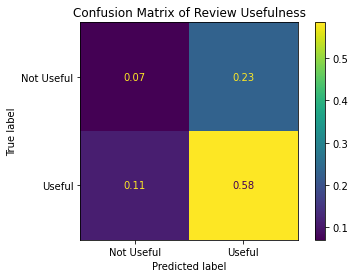

In [46]:
# Plot confusion matrix
y_true = y_test
y_pred = (classifier_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [48]:
# Evaluate model
loss, acc = classifier_model.evaluate(X_test, y_test)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

12/12 [==============================] - 2s 198ms/step - loss: 0.6359 - binary_accuracy: 0.6550
Model performance metrics on test data
Accuracy: 0.6550
Loss: 0.6359
Precision: 0.6154
Recall: 0.6550
F1-score: 0.6263


## X.X Sports

In [108]:
sports = review_samples[review_samples['category'] == 'sports']
labels = sports['useful'].astype(int)

### X.X Naive Bayes - Sports

In [109]:
reviews = sports['review_processed'].fillna('no review')

In [110]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_dev_tfidf = tf_idf.transform(X_dev)
X_test_tfidf = tf_idf.transform(X_test)

# Use SMOTE to resolve class imbalance
sm = SMOTE(random_state=0)
X_train_tfidf, y_train = sm.fit_resample(X_train_tfidf, y_train)

In [111]:
# Build model
nb_model = MultinomialNB(alpha=1.8)

# Fit model
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.8)

In [112]:
# Evaluate model accuracy
train_acc = nb_model.score(X_train_tfidf, y_train)
dev_acc = nb_model.score(X_dev_tfidf, y_dev)
test_acc = nb_model.score(X_test_tfidf, y_test)

print(train_acc, dev_acc, test_acc)

0.989648033126294 0.5384615384615384 0.47985347985347987


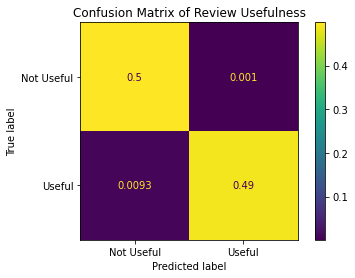

In [113]:
# Evaluate model on test data and plot confusion matrix
y_true = y_train
y_pred = nb_model.predict(X_train_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

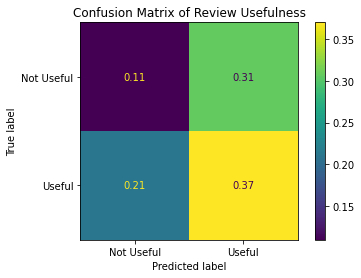

In [114]:
# Evaluate model on test data and plot confusion matrix
y_true = y_test
y_pred = nb_model.predict(X_test_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

AUC: 0.4492


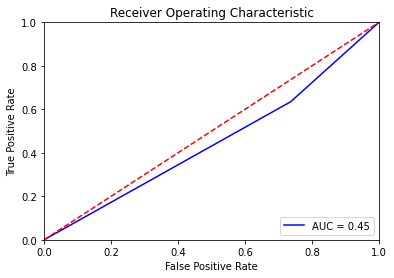

In [115]:
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [116]:
# Evaluate model
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(test_acc, precision, recall, f1))

Model performance metrics on test data
Accuracy: 0.4799
Precision: 0.4603
Recall: 0.4799
F1-score: 0.4660


### X.X Tokenization and analytics - Sports

In [ ]:
# Set tokenization parameters
num_words = 4000
num_len = 512
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize review text
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Additional tokenization parameters
max_words = len(tokenizer.word_index)
max_len = max([len(x) for x in sequences])

# Pad review text tokens
review_tokens = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=num_len)

In [ ]:
len(tokenizer.word_counts)

5583

In [ ]:
vocab = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'frequency'])
vocab.sort_values('frequency', ascending=False).head(10)

,word,frequency
73,use,491
160,great,350
20,get,344
68,good,322
139,one,312
177,like,297
349,work,271
34,well,268
153,would,267
123,make,260


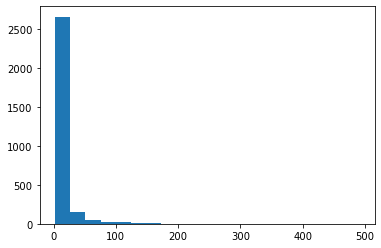

In [ ]:
filtered_vocab = vocab[vocab['frequency'] > 1]
plt.hist(filtered_vocab['frequency'], bins=20)
plt.show()

In [ ]:
print('Max words in vocabulary: {}'.format(max_words))
print('Max sequence length: {}'.format(max_len))
print('\n')

print('Words allowed in vocabulary: {}'.format(num_words))
print('Allowed sequence length: {}'.format(num_len))
print('\n')

print('Example processed review:')
print(review_samples['review_processed'].iloc[0])
print('\n')

print('Example tokenized review:')
print(review_tokens[0])

Max words in vocabulary: 5584
Max sequence length: 375


Words allowed in vocabulary: 4000
Allowed sequence length: 512


Example processed review:
works pissa


Example tokenized review:
[  73  163 1172  421  172   36  104  163   74  485 2046 2941 2942   33
 1173    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 

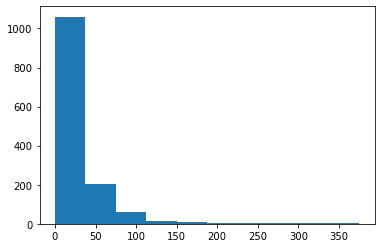

In [ ]:
seq_len = [len(x) for x in sequences]
d = {'sequence': sequences, 'length': seq_len}
seqs = pd.DataFrame(data = d)

plt.hist(seqs['length'])
plt.show()

In [ ]:
seqs[seqs['length'] > 512]

,sequence,length


### X.X CNN - Sports

In [ ]:
# Set model hyperparamters
output_dim = 256
epochs = 10
batch_size = 512
dropout_rate = 0.0
num_classes = len(np.unique(labels, axis=0))
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               epsilon=0.00000001,
                               clipnorm=1.0
                              )
loss_func = 'binary_crossentropy'
metrics = ['accuracy']

In [ ]:
# # Split data into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(review_tokens, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Use SMOTE to balance the training set
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
y_test.shape

(273,)

In [ ]:
# Build model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=num_words, output_dim=output_dim, input_length=num_len))
cnn_model.add(Conv1D(16, 3, padding='same', activation='relu'))
# cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer=opt, loss=loss_func, metrics=metrics)
cnn_model.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 512, 256)          1024000   
                                                                 
 conv1d_21 (Conv1D)          (None, 512, 16)           12304     
                                                                 
 flatten_20 (Flatten)        (None, 8192)              0         
                                                                 
 dense_45 (Dense)            (None, 256)               2097408   
                                                                 
 dense_46 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3,133,969
Trainable params: 3,133,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit model
cnn_model.fit(X_train,
              y_train,
              validation_data=(X_dev, y_dev),
              epochs=epochs,
              batch_size=batch_size,
              verbose=2
             )

Epoch 1/10
2/2 - 3s - loss: 0.7108 - accuracy: 0.4896 - val_loss: 0.6570 - val_accuracy: 0.6374 - 3s/epoch - 1s/step
Epoch 2/10
2/2 - 1s - loss: 0.7002 - accuracy: 0.5000 - val_loss: 0.6746 - val_accuracy: 0.6374 - 1s/epoch - 670ms/step
Epoch 3/10
2/2 - 1s - loss: 0.6837 - accuracy: 0.5021 - val_loss: 0.6767 - val_accuracy: 0.6740 - 1s/epoch - 671ms/step
Epoch 4/10
2/2 - 1s - loss: 0.6719 - accuracy: 0.6325 - val_loss: 0.6690 - val_accuracy: 0.6850 - 1s/epoch - 658ms/step
Epoch 5/10
2/2 - 1s - loss: 0.6552 - accuracy: 0.6429 - val_loss: 0.6627 - val_accuracy: 0.6813 - 1s/epoch - 670ms/step
Epoch 6/10
2/2 - 1s - loss: 0.6316 - accuracy: 0.6760 - val_loss: 0.6608 - val_accuracy: 0.6886 - 1s/epoch - 667ms/step
Epoch 7/10
2/2 - 1s - loss: 0.6002 - accuracy: 0.7505 - val_loss: 0.6605 - val_accuracy: 0.6923 - 1s/epoch - 674ms/step
Epoch 8/10
2/2 - 1s - loss: 0.5633 - accuracy: 0.8416 - val_loss: 0.6604 - val_accuracy: 0.6996 - 1s/epoch - 660ms/step
Epoch 9/10
2/2 - 1s - loss: 0.5199 - accura

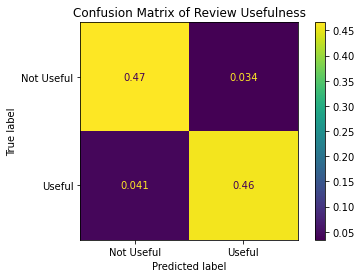

In [ ]:
# Plot confusion matrix on training data
y_true = y_train
y_pred = (cnn_model.predict(X_train) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

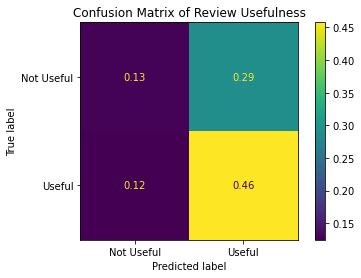

In [ ]:
# Plot confusion matrix
y_true = y_test
y_pred = (cnn_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.31      0.38       114
           1       0.61      0.79      0.69       159

    accuracy                           0.59       273
   macro avg       0.56      0.55      0.54       273
weighted avg       0.57      0.59      0.56       273



In [ ]:
# Evaluate model
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=1)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

9/9 [==============================] - 0s 11ms/step - loss: 0.7124 - accuracy: 0.5861
Model performance metrics on test data
Accuracy: 0.5861
Loss: 0.7124
Precision: 0.5687
Recall: 0.5861
F1-score: 0.5608


In [ ]:
def test_examples(model, examples, num_len=512):
    for idx, example in enumerate(examples):
        sequence = tokenizer.texts_to_sequences([example])
        test = pad_sequences(sequence, maxlen=num_len)
        prediction = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]
        print(idx, ":", prediction)

In [ ]:
test_examples(cnn_model, examples)

0 : Not Useful
1 : Not Useful
2 : Not Useful
3 : Not Useful
4 : Not Useful


### X.X BERT - Sports

In [50]:
reviews = sports['review_text'].fillna('no review')

X, y = reviews, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [51]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5245193]], shape=(1, 1), dtype=float32)


In [52]:
epochs = 10
steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [53]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss_func,
                         metrics=metrics)

In [54]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_train,
                               y=y_train,
                               validation_data=(X_dev, y_dev),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
26/26 [==============================] - 14s 251ms/step - loss: 0.8119 - binary_accuracy: 0.4878 - val_loss: 0.7553 - val_binary_accuracy: 0.3700
Epoch 2/10
26/26 [==============================] - 6s 225ms/step - loss: 0.7200 - binary_accuracy: 0.4534 - val_loss: 0.6647 - val_binary_accuracy: 0.5348
Epoch 3/10
26/26 [==============================] - 6s 228ms/step - loss: 0.6973 - binary_accuracy: 0.5331 - val_loss: 0.6446 - val_binary_accuracy: 0.5861
Epoch 4/10
26/26 [==============================] - 6s 228ms/step - loss: 0.6684 - binary_accuracy: 0.5674 - val_loss: 0.6370 - val_binary_accuracy: 0.6007
Epoch 5/10
26/26 [==============================] - 6s 229ms/step - loss: 0.6539 - binary_accuracy: 0.5784 - val_loss: 0.6297 - val_binary_accuracy: 0.6117
Epoch 6/10
26/26 [==============================] - 6s 226ms/step - loss: 0.6351 - binary_accuracy: 0.5735 - val_loss: 0.6294 -

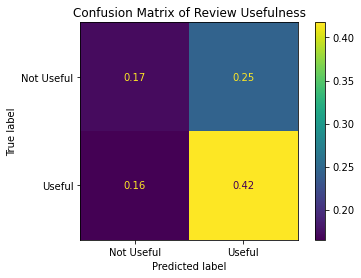

In [55]:
# Plot confusion matrix
y_true = y_test
y_pred = (classifier_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [56]:
# Evaluate model
loss, acc = classifier_model.evaluate(X_test, y_test)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

9/9 [==============================] - 2s 215ms/step - loss: 0.7170 - binary_accuracy: 0.5897
Model performance metrics on test data
Accuracy: 0.5897
Loss: 0.7170
Precision: 0.5802
Recall: 0.5897
F1-score: 0.5811
